# House price prediction

**This house price prediction model is built based on the result of transaction data analysis**

Data source:
    
1. Transaction records - Midland Realty

**Install libraries**

In [17]:
#!brew install libomp
#!pip3 install pandas
#!pip3 install scikit-learn
#!pip3 install xgboost

**Import libraries**

In [38]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.linear_model import Lasso

# **Data Importation and Pre-processing**

**Import Data**

In [2]:
# For google drive
#from google.colab import drive
#from google.colab import files

#drive.mount('/content/drive')
#data_dir = "/content/drive/My Drive/FYP/midland/"

In [3]:
# For local directory
data_dir = "./midland/"

In [4]:
hk_island = [
  "Chai_wan", "Heng_fa_chuen", "Shau_kei_wan", "Sai_wan_ho_tai_koo", "Quarry_bay", "North_point_fortress_hill", 
  "Braemar_hill_north_point_mid_level", "Jardines_lookout_tai_hang", "Happy_valley_mid_level_east", "Wan_chai_causeway_bay", 
  "Tin_hau", "Central_mid_level_admiralty", "Sheung_wan_central", "Hong_kong_west", "Western_mid_levels", "The_peak", 
  "Residence_bel_air_pokfulam", "Ap_lei_chau", "Aberdeen_wong_chuk_hang", "Repulse_bay_shou_son_hill", "Tai_tam_shek_o", "Stanley"
]

kowloon = [
  "Tsim_sha_tsui", "Kowloon_station", "Yau_ma_tei", "Kingspark", "Mongkok", "Tai_kok_tsui", "Olympic", "Lai_chi_kok", "Mei_foo", 
  "Cheung_sha_wan_sham_shui_po", "Yau_yat_tsuen", "Kowloon_tong_beacon_hill", "Ho_man_tin", "Hung_hum", "To_kwa_wan", "Kai_tak", 
  "Kowloon_city", "Wong_tai_sin_lok_fu", "Diamond_hill_san_po_kong_ngau_chi_wan", "Kowloon_bay", "Kwun_tong", "Lam_tin_yau_tong", 
  "Lohas_park", "Tiu_keng_leng", "Hang_hau", "Po_lam_tseung_kwan_o_station"
]

new_territory = [
  "Sai_kung_clear_water_bay", "Shatin", "Kau_to_shan_fotan", "Ma_on_shan", "Tai_po", "North", "Sheung_shui_fanling", "Hung_shui_kiu", 
  "Fairview_palm_springs_the_vineyard", "Tin_shui_wai", "Yuen_long", "Tuen_mun", "Tsuen_wan", "Sham_tseng", "Ma_wan", "Kwai_chung", 
  "Tsing_yi", "Discovery_bay", "Tung_chung", "Lan_tau_island"
]


In [14]:
# Data directory
dir_hk_island = "./hk_island/"
dir_kowloon = "./kowloon/"
dir_new_territory = "./new_territory/"

def get_data_by_region(region_name, disctrict_dir):

  region_df = pd.DataFrame()
  for region in region_name:
    new_df = pd.read_csv(data_dir+disctrict_dir+region+".csv")
    region_df = pd.concat([region_df, new_df], axis=0)

  # Data cleaning
  region_df = region_df.drop(region_df.columns[0], axis=1)

  region_df['tx_date'] = pd.to_datetime(region_df['tx_date'], dayfirst=True)
  region_df['first_op_date'] = pd.to_datetime(region_df['first_op_date'], dayfirst=True)
  region_df['last_tx_date'] = pd.to_datetime(region_df['last_tx_date'], dayfirst=True)

  region_df['floor'] = region_df['floor'].replace("-", np.nan)
  region_df['flat'] = region_df['flat'].replace("-", np.nan)

  region_df['area'] = region_df['area'].replace(0, np.nan)
  region_df['net_area'] = region_df['net_area'].replace(0, np.nan)
  region_df['last_price'] = region_df['last_price'].replace(0, np.nan)
  region_df['floor'] = region_df['floor'].astype('str') 
  region_df = region_df[~region_df['floor'].str.contains("&") == True]
  region_df['floor'] = region_df['floor'].replace("G", 0).replace("LG", 0).replace("LG1", 0)
  region_df['floor'] = region_df['floor'].apply(pd.to_numeric, errors = 'coerce')

  region_df.sort_values(by=['tx_date'], inplace=True, ascending=False)

  region_df = region_df.reset_index()
  region_df = region_df.drop(['index'], axis=1)
  return region_df

def download_data(filename, download_data):
  dataFrame = pd.DataFrame(data=download_data)
  dataFrame.to_csv(filename)
  files.download(filename)

# Get data by region
data_df_hk_island = get_data_by_region(hk_island, dir_hk_island)
data_df_kowloon = get_data_by_region(kowloon, dir_kowloon)
data_df_new_territory = get_data_by_region(new_territory, dir_new_territory)

# Get all region data
data_df_all = pd.concat([data_df_hk_island, data_df_kowloon, data_df_new_territory], axis=0)
data_df_all.sort_values(by=['tx_date'], inplace=True, ascending=False)
data_df_all = data_df_all.reset_index()
data_df_all = data_df_all.drop(['index'], axis=1)

data_df_all.columns = ['region', 'subregion', 'district', 'estate', 'building', 'firstOpDate',
                      'floorL', 'bedroom', 'sittingroom', 'floor', 'flat', 'grossArea', 'saleableArea',
                      'price', 'regDate', 'lastRegDate', 'lastPrice', 'gain', 'lat', 'lon']

**Feature Engineering**

In [6]:
def removeOutlier(df, col):
  # Calculate mean and standard deviation
  data_mean, data_std = np.mean(df[col]), np.std(df[col])

  # Calculate upper boundary
  upper = data_mean + data_std * 3
  
  # Remove outliers
  df = df[df[col] < upper]

  return df

In [15]:
processed_df = data_df_all.copy()

# Make new features
processed_df['buildingAge'] = pd.to_datetime("today").year - pd.DatetimeIndex(processed_df['firstOpDate']).year
processed_df['month'] = pd.to_datetime(processed_df['regDate']).dt.month
processed_df['year'] = pd.to_datetime(processed_df['regDate']).dt.year
processed_df['monthYear'] = pd.to_datetime(processed_df['regDate']).dt.to_period('M')

# Drop unneccessary columns and columns with too many missing values
processed_df = processed_df.drop(['firstOpDate', 'lastRegDate', 'sittingroom'], axis=1) 

# Fill missing values with 0
processed_df['floorL'] = processed_df['floorL'].fillna('Unknown')
processed_df['lat'] = processed_df['lat'].fillna(0)
processed_df['lon'] = processed_df['lon'].fillna(0)

# Fill missing values wiith mean values
bedroom_mean = processed_df['bedroom'].mean()
processed_df['bedroom'] = processed_df['bedroom'].fillna(bedroom_mean)
processed_df['bedroom'] = processed_df['bedroom'].astype(int)

saleableArea_mean = processed_df['grossArea'].mean()
processed_df['grossArea'] = processed_df['grossArea'].fillna(saleableArea_mean)

saleableArea_mean = processed_df['saleableArea'].mean()
processed_df['saleableArea'] = processed_df['saleableArea'].fillna(saleableArea_mean)

saleableArea_mean = processed_df['lastPrice'].mean()
processed_df['lastPrice'] = processed_df['lastPrice'].fillna(saleableArea_mean)

buildingAge_mean = processed_df['buildingAge'].mean()
processed_df['buildingAge'] = processed_df['buildingAge'].fillna(buildingAge_mean)
processed_df['buildingAge'] = processed_df['buildingAge'].astype(int)

floor_mean = processed_df['floor'].mean()
processed_df['floor'] = processed_df['floor'].fillna(floor_mean)
processed_df['floor'] = processed_df['floor'].astype(int)

# Label encoding for categorical features
cols = ('region', 'subregion', 'district', 'estate', 'building', 
        'floorL', 'flat', 'monthYear')
for col in cols:
    le = LabelEncoder() 
    le.fit(list(processed_df[col].values)) 
    processed_df[col] = le.transform(list(processed_df[col].values))

processed_df = removeOutlier(processed_df, 'price')
#processed_df = removeOutlier(processed_df, 'grossArea')
#processed_df = removeOutlier(processed_df, 'saleableArea')

**Feature Selection**

In [16]:
data_df = processed_df.copy()
data_df = data_df.drop(['flat', 'building', 'lat', 'lon', 'month', 'estate', 'monthYear', 'gain', 'year', 'floorL', 'district', 'subregion', 'regDate'], axis=1) 

# **Predictive Models**

In [17]:
# Random seed
RAND_SEED = 1234
# Size of training dataset
TRAIN_SIZE = 0.8

**Evaluation Metrics**

In [18]:
def rmsle(y, y_pred):
  return np.sqrt(mean_squared_log_error(y, y_pred))

**Train/Test split**

In [20]:
feat_col = [ c for c in data_df.columns if c not in ['price'] ]
x_df, y_df = data_df[feat_col], data_df['price']

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=RAND_SEED)

**Log Transformation**

In [21]:
log_y_train= np.log1p(y_train)

**XGB**

In [55]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', 
                       learning_rate = 0.1, max_depth = 5, alpha = 10, 
                       random_state=RAND_SEED, n_estimators = 1000)
model_xgb.fit(x_train, log_y_train)
xgb_train_pred = np.expm1(model_xgb.predict(x_train))
xgb_test_pred = np.expm1(model_xgb.predict(x_test))

XGBoost RMSLE(train):  0.1626671056150446
XGBoost RMSLE(test):  0.16849945199484243


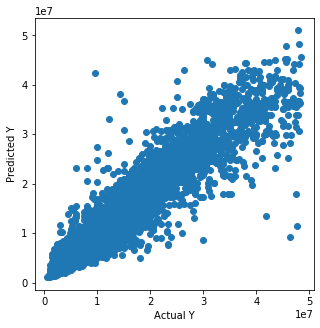

In [56]:
print("XGBoost RMSLE(train): ", rmsle(y_train, xgb_train_pred))
print("XGBoost RMSLE(test): ", rmsle(y_test, xgb_test_pred))

plt.figure(figsize=(5,5))
plt.scatter(y_test,xgb_test_pred)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.show()

**Random Forest**

In [75]:
model_rf = RandomForestRegressor(n_estimators = 100, max_depth=10, bootstrap=True, min_samples_leaf=10)
model_rf.fit(x_train, log_y_train)
rf_train_pred = np.expm1(model_rf.predict(x_train))
rf_test_pred = np.expm1(model_rf.predict(x_test))

Random Forest RMSLE(train):  0.18236381948722225
Random Forest RMSLE(test):  0.18951992159448278


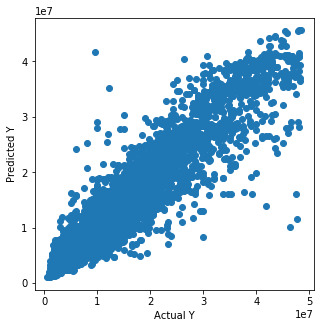

In [76]:
print("Random Forest RMSLE(train): ", rmsle(y_train, rf_train_pred))
print("Random Forest RMSLE(test): ", rmsle(y_test, rf_test_pred))

plt.figure(figsize=(5,5))
plt.scatter(y_test, rf_test_pred)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.show()

**Linear Regression**

In [45]:
model_lr = LinearRegression()
model_lr.fit(x_train, log_y_train)
lr_train_pred = np.expm1(model_lr.predict(x_train))
lr_test_pred = np.expm1(model_lr.predict(x_test))

Linear Regression RMSLE(train):  0.2628057466363474
Linear Regression RMSLE(test):  0.26502640161398383


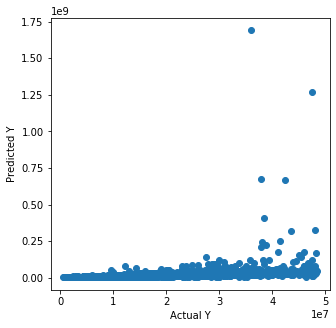

In [46]:
print("Linear Regression RMSLE(train): ", rmsle(y_train, lr_train_pred))
print("Linear Regression RMSLE(test): ", rmsle(y_test, lr_test_pred))

plt.figure(figsize=(5,5))
plt.scatter(y_test,lr_test_pred)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.show()

**Lasso**

In [48]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train,log_y_train)
lasso_train_pred = np.expm1(model_lasso.predict(x_train))
lasso_test_pred = np.expm1(model_lasso.predict(x_test))

Lasso RMSLE(train):  0.2638618800631309
Lasso RMSLE(test):  0.266233435415078


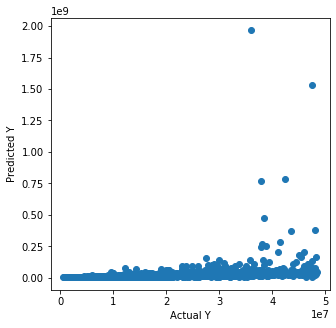

In [49]:
print("Lasso RMSLE(train): ", rmsle(y_train, lasso_train_pred))
print("Lasso RMSLE(test): ", rmsle(y_test, lasso_test_pred))

plt.figure(figsize=(5,5))
plt.scatter(y_test,lasso_test_pred)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.show()